# Alma Mosaic Imaging Test

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/imaging/alma_mosaic_test.ipynb).

## Installation


In [1]:
import os
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.84")
print('complete') 

complete


## Dataset

In [2]:
!gdown -q --id 16E-YPVLlgfth-2YVOdL8Uk3h3QT-73ck
!unzip Antennae_North_cal_lsrk.vis.zarr.zip > /dev/null

!gdown -q --id 1C_0ZarxgMo8mEdyDqs7IXf4IPlB7yzs9
!unzip Antennae_North_cal_lsrk_cube.img.zarr.zip > /dev/null

#%matplotlib widget

## Load Dataset

In [3]:
import xarray as xr
from cngi.dio import read_vis
#%matplotlib widget

xr.set_options(display_style="html")

infile = "Antennae_North_cal_lsrk.vis.zarr"
mxds = read_vis(infile)
print(mxds.xds0)


<xarray.Dataset>
Dimensions:         (baseline: 86, chan: 166, pol: 1, pol_id: 1, spw_id: 1, time: 1355, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 7 ... 78 79 80 81 82 83 84 85
  * chan            (chan) float64 3.449e+11 3.449e+11 ... 3.43e+11 3.43e+11
    chan_width      (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2011-05-28T01:41:17.375999451 ... 2...
Dimensions without coordinates: uvw_index
Data variables: (12/17)
    ANTENNA1        (baseline) int32 dask.array<chunksize=(86,), meta=np.ndarray>
    ANTENNA2        (baseline) int32 dask.array<chunksize=(86,), meta=np.ndarray>
    ARRAY_ID        (time, baseline) int32 dask.arr

## Grid Parameters

In [4]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [500,500]
grid_parms['cell_size'] = [0.13,0.13]
grid_parms['fft_padding'] = 1.0
grid_parms['phase_center'] = mxds.FIELD.PHASE_DIR[12,0,:].data.compute()

## Direction Rotation

The UVW coordinates must be rotated and the visbility DATA must be phase rotated, relative to the mosaic phase center specified by ```rotation_parms['image_phase_center']```. 

[direction_rotate documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_psf/index.html#ngcasa.imaging.direction_rotate.direction_rotate)

In [5]:
#Reload modules
%load_ext autoreload
%autoreload 2

In [6]:
from ngcasa.imaging import direction_rotate
import numpy as np
import dask
from cngi.vis import apply_flags

mxds0 = apply_flags(mxds, 'xds0', flags='FLAG')
 
xr.set_options(display_style="html")

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 0

rotation_parms = {}
rotation_parms['new_phase_center'] = grid_parms['phase_center']
rotation_parms['common_tangent_reprojection'] = True
rotation_parms['single_precision'] = True


mxds1 = direction_rotate(mxds0, rotation_parms, sel_parms)
mxds1.xds0.data_groups

######################### Start direction_rotate #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
######################### Created graph for direction_rotate #########################


[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'DATA_ROT',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW_ROT',
   'weight': 'DATA_WEIGHT'}}]

In [7]:
print(mxds.xds0)

<xarray.Dataset>
Dimensions:         (baseline: 86, chan: 166, pol: 1, pol_id: 1, spw_id: 1, time: 1355, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 7 ... 78 79 80 81 82 83 84 85
  * chan            (chan) float64 3.449e+11 3.449e+11 ... 3.43e+11 3.43e+11
    chan_width      (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2011-05-28T01:41:17.375999451 ... 2...
Dimensions without coordinates: uvw_index
Data variables: (12/17)
    ANTENNA1        (baseline) int32 dask.array<chunksize=(86,), meta=np.ndarray>
    ANTENNA2        (baseline) int32 dask.array<chunksize=(86,), meta=np.ndarray>
    ARRAY_ID        (time, baseline) int32 dask.arr

## Make Imaging Weights

[make_imaging_weight documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_imaging_weight/index.html#ngcasa.imaging.make_imaging_weight.make_imaging_weight)

In [8]:
from ngcasa.imaging import make_imaging_weight
import matplotlib.pylab as plt

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 1

mxds2 = make_imaging_weight(mxds1, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


## Make Gridding Convolution Functions

[make_gridding_convolution_function](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_gridding_convolution_function/index.html#ngcasa.imaging.make_gridding_convolution_function.make_gridding_convolution_function)



In [9]:
from ngcasa.imaging import make_gridding_convolution_function
import numpy as np
import dask.array as da
from cngi.dio import write_image

gcf_parms = {}
gcf_parms['function'] = 'alma_airy'
gcf_parms['list_dish_diameters'] = np.array([10.7])
gcf_parms['list_blockage_diameters'] = np.array([0.75])

unique_ant_indx = mxds.ANTENNA.DISH_DIAMETER.values
unique_ant_indx[unique_ant_indx == 12.0] = 0

gcf_parms['unique_ant_indx'] = unique_ant_indx.astype(int)
gcf_parms['phase_center'] = grid_parms['phase_center']

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 1

gcf_xds = make_gridding_convolution_function(mxds2, gcf_parms, grid_parms, sel_parms)
write_image(gcf_xds,'mosaic_gcf.gcf.zarr')
gcf_xds = xr.open_zarr('mosaic_gcf.gcf.zarr')

######################### Start make_gridding_convolution_function #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default chan_tolerance_factor  to  0.005
Setting default oversampling  to  [10, 10]
Setting default max_support  to  [15, 15]
Setting default support_cut_level  to  0.025
Setting default a_chan_num_chunk  to  3
Setting default image_center  to  [250 250]
#########################  Created graph for make_gridding_convolution_function #########################
Time to store and execute graph  write_zarr 0.9471564292907715


## Make Mosaic Primary Beam and Image

[make_mosaic_pb](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_mosaic_pb/index.html#ngcasa.imaging.make_mosaic_pb.make_mosaic_pb)

[make_image_with_gcf](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_image_with_gcf/index.html#ngcasa.imaging.make_image_with_gcf.make_image_with_gcf)

In [10]:
from ngcasa.imaging import make_mosaic_pb

vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 1

img_sel_parms = {}
img_xds= xr.Dataset()

img_xds = make_mosaic_pb(mxds2,gcf_xds,img_xds,vis_sel_parms,img_sel_parms,grid_parms)

###############################################

from ngcasa.imaging import make_image_with_gcf
from cngi.dio import write_image, read_image

vis_select_parms = {}
vis_select_parms['xds'] = 'xds0'
vis_select_parms['data_group_in_id'] = 1

img_select_parms = {}
img_select_parms['data_group_in_id'] = 0

norm_parms = {}
norm_parms['norm_type'] = 'flat_sky'
#norm_parms['norm_type'] = 'none'

img_xds = make_image_with_gcf(mxds2,gcf_xds, img_xds, grid_parms, norm_parms, vis_select_parms, img_select_parms)

write_image(img_xds,'mosaic_img.img.zarr')
img_xds = read_image('mosaic_img.img.zarr')

######################### Start make_mosaic_pb #########################
Setting default image_center  to  [250 250]
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out  to  {'id': '0', 'pb': 'PB', 'weight_pb': 'WEIGHT_PB', 'weight_pb_sum_weight': 'WEIGHT_PB_SUM_WEIGHT'}
#########################  Created graph for make_mosaic_pb #########################
######################### Start make_image_with_gcf #########################
Setting default image_center  to  [250 250]
Setting default single_precision  to  True
Setting default pb_limit  to  0.2
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW_ROT', 'weight': 'DA

/usr/local/lib/python3.7/dist-packages/ngcasa/imaging/_imaging_utils/_normalize.py:51: RuntimeWarning: invalid value encountered in true_divide
  normalized_image = (image / sum_weights_copy) / (oversampling_correcting_func[:,:,None,None]*normalizing_image)


Time to store and execute graph  write_zarr 40.443665981292725


## Compare CASA and ngCASA Primary Beams

Frequency 343.9505596639216 GHz


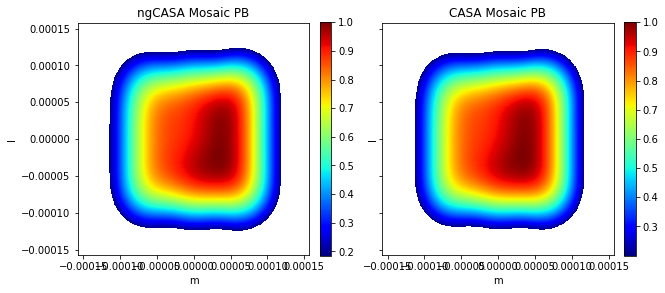

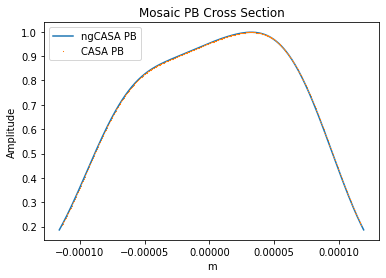

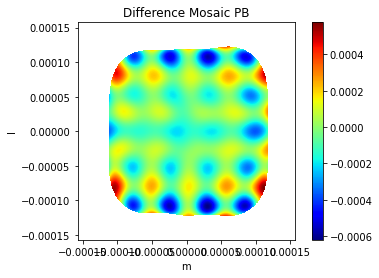

In [11]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive
import scipy
from scipy.signal import decimate
from cngi.image import implot
import xarray as xr

img_xds = xr.open_zarr('mosaic_img.img.zarr').isel(time=0,pol=0)
casa_img_xds = xr.open_zarr('Antennae_North_cal_lsrk_cube.img.zarr').isel(time=0,pol=0)
pb_limit = 0.2
extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

#print(casa_img_xds)

def comparison_plots(chan):
    plt.close('all')
    print('Frequency',img_xds.chan[chan].values/10**9, 'GHz')
    mosaic_pb = img_xds.PB.isel(chan=chan)
    mosaic_pb = mosaic_pb.where(mosaic_pb > pb_limit,other=np.nan)
    mosaic_pb = mosaic_pb/np.max(mosaic_pb)
    
    casa_mosaic_pb = casa_img_xds.PB.isel(chan=chan)
    casa_mosaic_pb = casa_mosaic_pb.where(casa_mosaic_pb > pb_limit,other=np.nan)

    fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
    im0 = ax0[0].imshow(mosaic_pb,cmap='jet',extent=extent)
    im1 = ax0[1].imshow(casa_mosaic_pb,cmap='jet',extent=extent)
    ax0[0].title.set_text('ngCASA Mosaic PB')
    ax0[1].title.set_text('CASA Mosaic PB')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'), ax0[1].set_ylabel('l')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    
    plt.figure()
    plt.plot(casa_mosaic_pb.m,mosaic_pb.isel(l=300),label='ngCASA PB')
    plt.plot(casa_mosaic_pb.m,casa_mosaic_pb.isel(l=300),'*',label='CASA PB',markersize=0.5)
    plt.legend()
    plt.xlabel('m')
    plt.ylabel('Amplitude')
    plt.title('Mosaic PB Cross Section')
    
    diff_image = mosaic_pb - casa_mosaic_pb
    plt.figure()
    plt.imshow(mosaic_pb - casa_mosaic_pb,extent=extent,cmap='jet')
    plt.xlabel('m'), plt.ylabel('l')
    plt.colorbar()
    plt.title('Difference Mosaic PB')
    plt.show()

#interactive_plot = interactive(comparison_plots, chan=(0, len(img_xds.chan)-1))
#output = interactive_plot.children[-1]
#output.layout.auto_scroll_threshold = 9999;
#interactive_plot
comparison_plots(82)


## Compare CASA and ngCASA Sky Images

Frequency 343.9505596639216 GHz


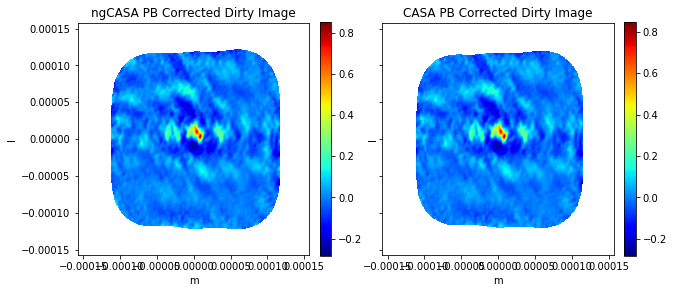

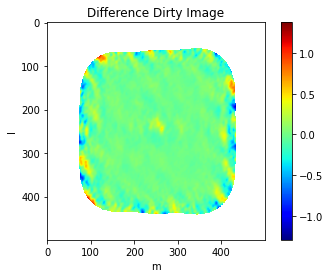

In [12]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive
import scipy
from scipy.signal import decimate
import xarray as xr

img_xds = xr.open_zarr('mosaic_img.img.zarr',chunks={'l':grid_parms['image_size'][0],'m':grid_parms['image_size'][1]}).isel(time=0,pol=0)
casa_img_xds = xr.open_zarr('Antennae_North_cal_lsrk_cube.img.zarr',chunks={'l':grid_parms['image_size'][0],'m':grid_parms['image_size'][1]}).isel(time=0,pol=0)
pb_limit = 0.22
extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

ngcasa_image_name = 'IMAGE'
casa_image_name = 'IMAGE_PBCOR'
#casa_image_name = 'IMAGE'
 
def comparison_plots(chan):
    print('Frequency',img_xds.chan.isel(chan=chan).values/10**9, 'GHz')
    mosaic_pb = img_xds.PB.isel(chan=chan)
    casa_mosaic_pb = casa_img_xds.PB.isel(chan=chan)
    
    mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
    mosaic_img = mosaic_img.where(mosaic_pb > pb_limit,other=np.nan)
    
    casa_mosaic_img = casa_img_xds[casa_image_name].isel(chan=chan)
    casa_mosaic_img = casa_mosaic_img.where(casa_mosaic_pb > pb_limit,other=np.nan)
    
    fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
    im0 = ax0[0].imshow(mosaic_img,cmap='jet',extent=extent)
    im1 = ax0[1].imshow(casa_mosaic_img,cmap='jet',extent=extent)
    ax0[0].title.set_text('ngCASA PB Corrected Dirty Image')
    ax0[1].title.set_text('CASA PB Corrected Dirty Image')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'), ax0[1].set_ylabel('l')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    
    plt.figure()
    plt.imshow((100*(mosaic_img.data - casa_mosaic_img.data)/np.nanmax(casa_mosaic_img.data)),cmap='jet')
    plt.title('Difference Dirty Image')
    plt.xlabel('m'), plt.ylabel('l')
    plt.colorbar()
    plt.show()

#interactive_plot = interactive(comparison_plots, chan=(0, len(img_xds.chan)-1))
#output = interactive_plot.children[-1]
#output.layout.auto_scroll_threshold = 9999;
#interactive_plot
comparison_plots(82)


/usr/local/lib/python3.7/dist-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.7/dist-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.7/dist-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/usr/local/lib/python3.7/dist-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


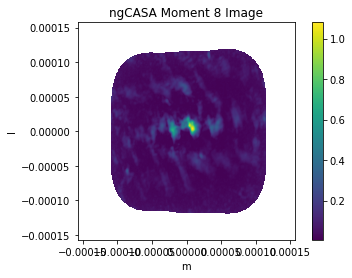

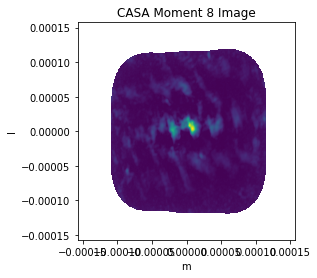

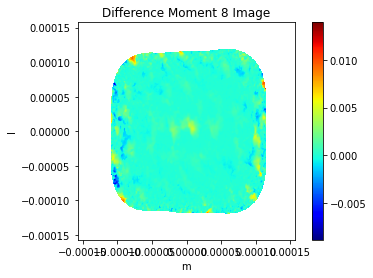

In [13]:
from cngi.image.moments import moments

chan_slice = slice(0,139)
img_xds.attrs['rest_frequency'] = casa_img_xds.attrs['rest_frequency']

pb_limit = 0.25
img_xds_pb_cut = img_xds.copy(deep=True)
img_xds_pb_cut['IMAGE'] = img_xds['IMAGE'].where(img_xds['PB'].data > pb_limit,other=np.nan)
img_xds_mom8 = moments(img_xds_pb_cut.isel(chan=chan_slice), moment=8, axis='chan')
img_mom8 = img_xds_mom8.MOMENTS_MAXIMUM

casa_img_xds_pb_cut = casa_img_xds.copy(deep=True)
casa_img_xds_pb_cut['IMAGE'] = casa_img_xds['IMAGE_PBCOR'].where(img_xds['PB'].data > pb_limit,other=np.nan)
casa_img_xds_mom8 = moments(casa_img_xds_pb_cut.isel(chan=chan_slice), moment=8, axis='chan')
casa_img_mom8 = casa_img_xds_mom8.MOMENTS_MAXIMUM

plt.figure()
plt.imshow(img_mom8,extent=extent)
plt.title('ngCASA Moment 8 Image')
plt.xlabel('m'), plt.ylabel('l')
plt.colorbar()

plt.figure()
plt.imshow(casa_img_mom8,extent=extent)
plt.title('CASA Moment 8 Image')
plt.xlabel('m'), plt.ylabel('l')

plt.figure()
plt.imshow((img_mom8 - casa_img_mom8)/np.nanmax(casa_img_mom8),cmap='jet',extent=extent)
plt.title('Difference Moment 8 Image')
plt.xlabel('m'), plt.ylabel('l')
plt.colorbar()


<xarray.DataArray 'IMAGE' (l: 500, m: 500, chan: 166)>
dask.array<where, shape=(500, 500, 166), dtype=float64, chunksize=(500, 500, 10), chunktype=numpy.ndarray>
Coordinates:
  * chan             (chan) float64 3.449e+11 3.449e+11 ... 3.43e+11 3.43e+11
    chan_width       (chan) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    declination      (l, m) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * l                (l) float64 0.0001576 0.0001569 ... -0.0001563 -0.0001569
  * m                (m) float64 -0.0001576 -0.0001569 ... 0.0001563 0.0001569
    pol              int32 9
    right_ascension  (l, m) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    time             datetime64[ns] 2011-06-04T07:26:13.328236156


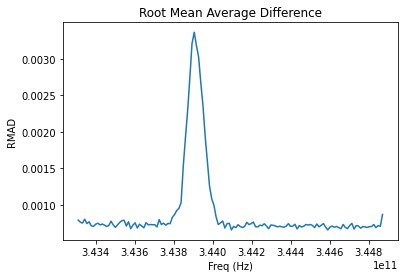

In [14]:
from cngi.image.moments import moments


pb_limit = 0.2
img_xds_pb_cut = img_xds.copy(deep=True)
ngcasa_pbcor = img_xds['IMAGE'].where(img_xds['PB'].data > pb_limit,other=np.nan)

casa_img_xds_pb_cut = casa_img_xds.copy(deep=True)
casa_pbcor = casa_img_xds['IMAGE_PBCOR'].where(img_xds['PB'].data > pb_limit,other=np.nan)

rmad_per_channel = np.nanmean(np.abs(ngcasa_pbcor.data-casa_pbcor.data),axis=(0,1))

print(ngcasa_pbcor)
plt.figure()
plt.plot(ngcasa_pbcor.chan[:140],rmad_per_channel[:140])
plt.title('Root Mean Average Difference')
plt.ylabel('RMAD')
plt.xlabel('Freq (Hz)')
plt.show()


